# BCG X Challenge - Amigos do Bem

Transformando o sertão com dados!

O Amigos do Bem é uma organização sem fins lucrativos que atua há 30 anos no sertão nordestino, transformando vidas por meio de ações de educação, saúde, trabalho e renda. A organização atende mais de 150 mil pessoas em 300 povoados, localizadas em 3 estados do Nordeste: Alagoas, Ceará e Pernambuco.

Assim, viu-se a necessidade de criar um padrão de avaliação de impacto social, que permitisse a comparação entre os povoados atendidos pela organização. Para isso, foi criado o Índice de Desenvolvimento Humano Sertão (IDHSertão), que é composto por 3 dimensões: educação, saúde e renda. Cada dimensão é composta por 3 indicadores, que por sua vez são compostos por 3 variáveis. O IDHSertão é calculado a partir da média ponderada dos indicadores, que são calculados a partir da média ponderada das variáveis.


Grupo 14

Integrantes:
- Marcos Vinícius Moura
- Priscila Falcão
- Raphael Lisboa Antunes
- Thomas Barton

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split

### Tratamento das bases de dados

#### Importação das bases de dados disponíveis

In [2]:
# Importando dados dos municípios do semiárido

municipios = pd.read_excel("Dados/Municipios/lista-1262municipios-semiarido-2017.xlsx")
municipios = municipios.rename(columns=municipios.iloc[1])
municipios = municipios.drop([0, 1]).reset_index(drop=True)
municipios = municipios.drop('#', axis=1).reset_index(drop=True)

In [3]:
municipios_todos = pd.read_csv("Dados/Municipios/municipios.csv")
municipios_todos = municipios_todos[(municipios_todos['codigo_ibge'].isin(municipios['Cod IBGE']))]

In [4]:
censo = pd.read_csv("Dados/Censo/Censo_municipal_estadual_nacional-MUN91-00-10.csv")
censo = censo[(censo['Codmun7'].isin(municipios['Cod IBGE']))]
censo_siglas = pd.read_csv("Dados/Censo/Censo_municipal_estadual_nacional-Siglas.csv")

In [5]:
idh_tot = pd.read_csv("Dados/Registros_Administrativos/dados_registros_administrativos_total_2012_2027.csv")

In [6]:
# Dados de municípios do sertão nordestino pegos do site oficial do IBGE por estado, tratados e concatenados em um único csv

dados_ibge = pd.read_csv("Dados/Dados IBGE/Dados IBGE.csv")
dados_ibge = dados_ibge[(dados_ibge['Munic&iacute;pio [-]'].isin(municipios['Cod IBGE']))]

In [7]:
# Informações dos estados do setão nordestino pegos do site oficial do IBGE

todos_estados = pd.read_csv("Dados/Dados IBGE/Estados IBGE.csv")
todos_estados = todos_estados[todos_estados['C&oacute;digo [-]'].isin(municipios_todos['codigo_uf'])]

#### Criação de um novo dataframe em pandas para realizar o tratamento de dados

In [8]:
# Junção das informações de identificação e IDHs das bases de dado de registros administrativos e censo

idh_tot_to_merge = idh_tot.drop_duplicates(subset='IBGE7', keep='last').reset_index(drop=True)
censo_to_merge = censo.drop_duplicates(subset='Codmun7', keep='last').reset_index(drop=True)
censo_idh_merged = pd.merge(idh_tot_to_merge[['IBGE7', 'NOME', 'POP_TOT']], censo_to_merge[['Codmun7', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']], left_on='IBGE7', right_on='Codmun7', how='inner')
df = censo_idh_merged.drop('Codmun7', axis=1)

In [9]:
# Adição das informações territoriais (estado, latitude e longitude)

df = pd.merge(df, municipios[['Cod IBGE', 'UF']], left_on='IBGE7', right_on='Cod IBGE', how='inner')
df = pd.merge(df, municipios_todos[['codigo_ibge', 'latitude', 'longitude']], left_on='IBGE7', right_on='codigo_ibge', how='inner')
df = df.drop(['Cod IBGE', 'codigo_ibge'], axis=1)
df = df.sort_values(by='IBGE7')

In [10]:
# Adição das informações de área do município e densidade demográfica

dados_ibge = dados_ibge.sort_values(by='Munic&iacute;pio [-]').reset_index(drop=True)
df['AREA_KM²'] = dados_ibge['Prefeito [2021]']
df['POP/KM²'] = dados_ibge['Popula&ccedil;&atilde;o residente - pessoas [2022]']

In [11]:
# Análise dos municípios em que os Amigos do Bem já atuam, ordenados por IDHM

df[(df['IBGE7'].isin([2602803, 2607000, 2308104, 2708402]))].sort_values(by=['IDHM'])

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
753,2607000,Inajá,22801,0.523,0.400,0.711,0.503,PE,-8.90206,-37.8351,1231.362,20.79
722,2602803,Buíque,57696,0.527,0.395,0.746,0.497,PE,-8.61954,-37.1606,1336.544,38.98
861,2708402,São José da Tapera,32626,0.527,0.409,0.703,0.508,AL,-9.55768,-37.3831,490.879,62.35
290,2308104,Mauriti,46548,0.605,0.526,0.772,0.544,CE,-7.38597,-38.7708,1079.011,42.22


In [12]:
# Municípios do sertão com IDHM menor ou igual a 0.5 ordenados (a média do sertão é 0.55)

df[df['IDHM'] <= 0.5].sort_values(by='IDHM')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
840,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77
151,2209658,São Francisco de Assis do Piauí,5657,0.485,0.336,0.734,0.462,PI,-8.23599,-41.6873,1072.311,5.20
1016,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34
769,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94
49,2202653,Caxingó,5330,0.488,0.329,0.708,0.498,PI,-3.41904,-41.8955,491.093,11.19
23,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73
851,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68
50,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80
52,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66
14,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41


In [13]:
# Municípios com população maior ou igual a 15000 e IDHM menor ou igual a 0.5 ordenados (média do sertão é 0.55)

df[(df['POP_TOT'] >= 15000) & (df['IDHM'] < 0.5)].sort_values(by='IDHM')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
840,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77
1016,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34
769,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94
50,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80


In [14]:
# Ordenação de estados por IDH

todos_estados.sort_values(by='IDH &lt;span&gt;Índice de desenvolvimento humano&lt;/span&gt; [2021]')

,UF [-],C&oacute;digo [-],Gent&iacute;lico [-],Governador [2023],Capital [2010],&Aacute;rea Territorial - km&sup2; [2022],Popula&ccedil;&atilde;o residente - pessoas [2022],Densidade demogr&aacute;fica - hab/km&sup2; [2022],Matrículas no ensino fundamental - matr&iacute;culas [2021],IDH &lt;span&gt;Índice de desenvolvimento humano&lt;/span&gt; [2021],Receitas realizadas - R$ (&times;1000) [2017],Despesas empenhadas - R$ (&times;1000) [2017],Rendimento mensal domiciliar per capita - R$ [2022],Total de ve&iacute;culos - ve&iacute;culos [2022]
9,Maranh&atilde;o,21,maranhense,CARLOS ORLEANS BRAND&Atilde;O J&Uacute;NIOR,S&atilde;o Lu&iacute;s,329651.496,6775152,20.55,1112636,0.676,1.850326e+07,1.762717e+07,814,2031236
1,Alagoas,27,alagoano,PAULO SURUAGY DO AMARAL DANTAS,Macei&oacute;,27830.661,3127511,112.38,458782,0.684,1.195044e+07,1.046063e+07,935,1034187
17,Piau&iacute;,22,piauiense,RAFAEL TAJRA FONTELES,Teresina,251755.481,3269200,12.99,459871,0.690,1.212422e+07,9.676736e+06,1110,1385426
4,Bahia,29,baiano,JER&Ocirc;NIMO RODRIGUES SOUZA,Salvador,564760.429,14136417,25.03,1946957,0.691,5.019100e+07,4.557016e+07,1010,4887673
14,Para&iacute;ba,25,paraibano,JO&Atilde;O AZEVEDO LINS FILHO,Jo&atilde;o Pessoa,56467.242,3974495,70.39,540919,0.698,1.309701e+07,1.007470e+07,1096,1523167
25,Sergipe,28,sergipano ou sergipense,F&Aacute;BIO CRUZ MITIDIERI,Aracaju,21938.188,2209558,100.72,320638,0.702,1.014505e+07,8.494927e+06,1187,907388
16,Pernambuco,26,pernambucano,RAQUEL TEIXEIRA LYRA LUCENA,Recife,98067.877,9058155,92.37,1249850,0.719,3.574603e+07,3.332049e+07,1010,3439164
19,Rio Grande do Norte,24,potiguar ou norte-rio-grandense ou rio-grand...,MARIA DE FATIMA BEZERRA,Natal,52809.599,3302406,62.53,447692,0.728,1.352755e+07,1.133096e+07,1267,1495094
5,Cear&aacute;,23,cearense,ELMANO DE FREITAS DA COSTA,Fortaleza,148894.447,8791688,59.05,1161434,0.734,2.842022e+07,2.460835e+07,1050,3625994
12,Minas Gerais,31,mineiro,ROMEU ZEMA NETO,Belo Horizonte,586513.983,20538718,35.02,2407107,0.774,9.719982e+07,9.839167e+07,1529,13028883


In [15]:
# Valores de IDH por estado, pegando a média dos IDHMs das cidades de cada estado

df.groupby('UF')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].mean().sort_values(by='IDHM')

,IDHM,IDHM_E,IDHM_L,IDHM_R
UF,,,,
AL,0.550763,0.424947,0.739342,0.533632
PI,0.570832,0.456903,0.747827,0.547308
MA,0.585000,0.490500,0.738500,0.555500
PE,0.585154,0.473504,0.749797,0.566748
BA,0.585554,0.475133,0.754540,0.562388
SE,0.586000,0.472345,0.745207,0.574103
PB,0.588541,0.478737,0.757345,0.564144
RN,0.609762,0.516354,0.762707,0.577395
MG,0.613231,0.504132,0.792835,0.579209


In [16]:
# Definição de quais seriam as cidades para a realização da escolha e a análise estratégica
final_towns = df[(df['POP_TOT'] >= 6000) & (df['IDHM'] < 0.52)].copy().reset_index(drop=True)

transporte = pd.read_csv("Dados/Transportes/transport_cost.csv")
transporte = transporte[(transporte['codigo_ibge'].isin(final_towns['IBGE7']))]
min_cost_indices = transporte.groupby('codigo_ibge')['transportation_cost'].idxmin()
transporte = transporte.loc[min_cost_indices].sort_values(by=['codigo_ibge'])
final_towns['CUSTO_TRANSPORTE'] = transporte['transportation_cost'].reset_index(drop=True)
final_towns = final_towns.sort_values(by='IDHM')

# Seleção dos mais pre
final_towns = final_towns[0:10]

# Adição de colunas de distância a fim de analisar a logística de transporte e expansão
final_towns['DIST_MAURITI_KM'] = [432, 578, 255, 334, 470, 724, 718, 430, 446, 440]
final_towns['DIST_INAJA_KM'] = [43.4, 358, 31.6, 493, 110, 1066, 1060, 755, 29.4, 395]
final_towns['DIST_CATIMBAU_KM'] = [148, 453, 82.7, 523, 175, 1087, 1039, 734, 143, 489]
final_towns['DIST_TORROES_KM'] = [65.7, 287, 100, 581, 31.2, 1154, 1148, 828, 94, 385]

final_towns

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²,CUSTO_TRANSPORTE,DIST_MAURITI_KM,DIST_INAJA_KM,DIST_CATIMBAU_KM,DIST_TORROES_KM
14,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77,24731.10036,432,43.4,148.0,65.7
18,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34,23766.05503,578,358.0,453.0,287.0
10,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94,24832.77179,255,31.6,82.7,100.0
1,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73,26467.79064,334,493.0,523.0,581.0
16,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68,24365.85067,470,110.0,175.0,31.2
2,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80,29323.30652,724,1066.0,1087.0,1154.0
3,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66,29199.14421,718,1060.0,1039.0,1148.0
0,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41,27805.60005,430,755.0,734.0,828.0
15,2705002,Mata Grande,25589,0.504,0.369,0.685,0.506,AL,-9.11824,-37.7323,914.722,23.88,24784.14603,446,29.4,143.0,94.0
20,2921500,Monte Santo,51953,0.506,0.359,0.699,0.515,BA,-10.43740,-39.3321,3034.197,15.75,24661.74527,440,395.0,489.0,385.0


### Análise exploratória dos dados

#### Correlação dos dados

Uma matriz de correlação ajuda a entender como as variáveis no seu conjunto de dados estão relacionadas entre si. Através da análise das correlações, é possível identificar se existem associações positivas ou negativas entre variáveis. Isso é fundamental para compreender a natureza dos dados e pode ser usado para gerar insights.

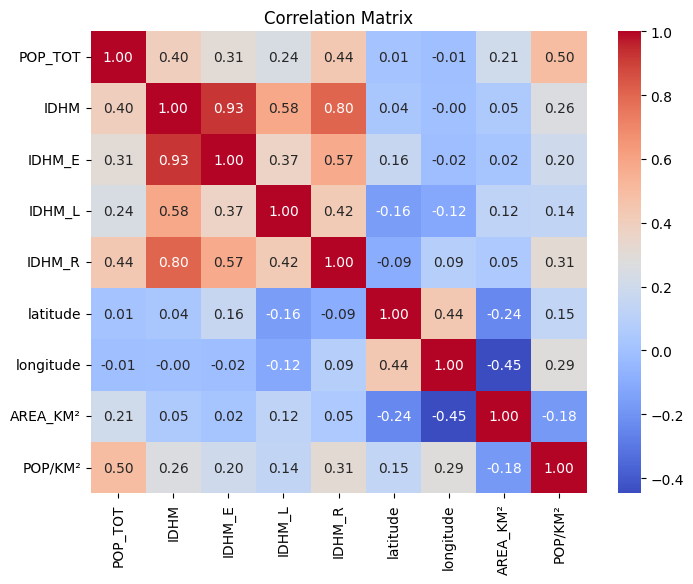

In [17]:
# Correlação dos dados do dataframe tratado

correlation_df = df.copy()
correlation_df = correlation_df.drop(['IBGE7', 'NOME', 'UF'], axis=1)
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Text(0, 0.5, 'IDHM_E')

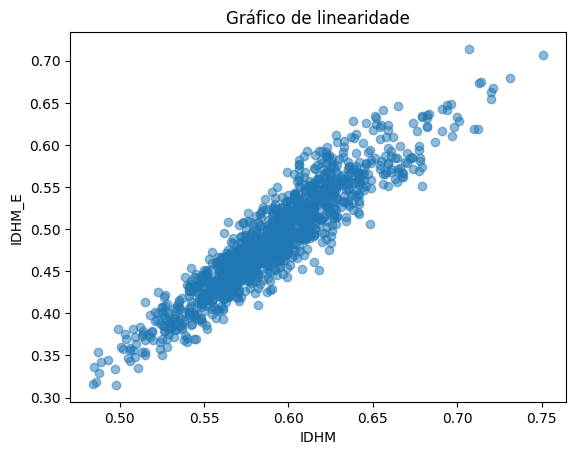

In [18]:
# Gráfico mostrando a linearidade entre os valores de IDHM e IDHM_E

x = df['IDHM']
y = df['IDHM_E']

df[(df['POP_TOT'] >= 15000) & (df['IDHM'] < 0.52)]['IDHM']

plt.scatter(x, y, alpha=0.5)
plt.title('Gráfico de linearidade')
plt.xlabel('IDHM')
plt.ylabel('IDHM_E')

**IDHM_E:** Existe uma correlação forte e positiva entre o Índice de Desenvolvimento Humano Municipal (IDHM) e o subíndice de Educação (IDHM_E). Isso sugere que um bom desempenho em indicadores educacionais está associado a um IDH mais alto.

**IDHM_R:** O subíndice de Renda (IDHM_R) também apresenta uma correlação positiva com o IDHM, embora um pouco menos forte do que a correlação com o IDHM_E.

**População e Área Geográfica:** A análise revela também que os dados de população e área geográfica dos municípios têm correlações relativamente baixas com o IDH. No entanto, destaca-se que a densidade populacional tem uma influência ligeiramente maior no IDH, em comparação com outras variáveis relacionadas à população e área.

#### Modelo preditivo

Para obter uma visão mais completa e aprofundada dos dados que estamos observando, aplicamos um modelo preditivo. Essa abordagem vai além da mera análise descritiva, permitindo-nos identificar relações de dados mais complexas e nos permitindo ver a correlação dos dados com uma maior profundidade.

In [19]:
# Separação dos dados para treinar o modelo preditivo

data = censo.copy()
X = data.drop(['ANO', 'Codmun6', 'Codmun7', 'Município'], axis=1).dropna()
y = X['IDHM']
X = X.drop(['IDHM'], axis=1)

In [20]:
# Criação, hiperparametrização e treinamento do modelo, utilizando a biblioteca LightGBM

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.05,
    "num_iterations": 100,
}


gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X, y)

c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(learning_rate=0.05, num_iterations=100, objective='regression',
              task='train')

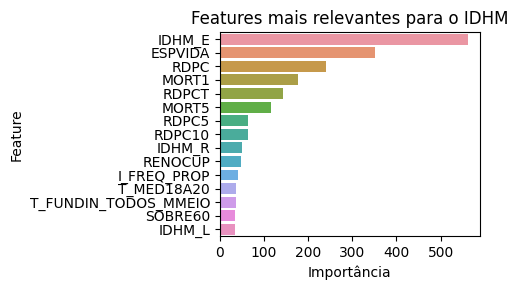

In [21]:
# Gráfico demonstrando as 15 colunas que mais influenciam na predição, com seus respectivos pesos

feature_importance = pd.DataFrame(sorted(zip(gbm.feature_importances_, X.columns), reverse=True), columns=['Importância', 'Feature'])
top_20_features = feature_importance.head(15)

plt.figure(figsize=(5, 3))
sns.barplot(x="Importância", y="Feature", data=top_20_features)
plt.title('Features mais relevantes para o IDHM')
plt.tight_layout()
plt.show()

**IDHM_E:** Como demonstrado na matriz de correlação, aqui também foi possível identificar que o subíndice de Educação (IDHM_E) apresenta uma influência significativa no valor do IDHM. Essa correlação forte destaca a importância dos indicadores educacionais no cálculo do IDHM.

**Ênfase em Variáveis de Renda:** Além disso, a observação dos atributos mais destacados pelo modelo de previsão reforça a presença significativa de dados relacionados à renda. Isso sugere que o poder aquisitivo e a distribuição de renda têm um papel considerável na determinação do IDHM.

**Impacto da Mortalidade e Longevidade:** A análise revela que as variáveis relacionadas à mortalidade e longevidade desempenham um papel mais significativo do que inicialmente aparentado (na matriz de correlação). Essas variáveis emergem repetidamente na lista de características de maior importância, sublinhando sua influência substancial no cálculo do IDHM.

### Análise dos custos

#### Transporte

In [22]:
# Análise dos custos de transporte dos municípios filtrados

final_towns.sort_values(by='CUSTO_TRANSPORTE')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²,CUSTO_TRANSPORTE,DIST_MAURITI_KM,DIST_INAJA_KM,DIST_CATIMBAU_KM,DIST_TORROES_KM
18,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34,23766.05503,578,358.0,453.0,287.0
16,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68,24365.85067,470,110.0,175.0,31.2
20,2921500,Monte Santo,51953,0.506,0.359,0.699,0.515,BA,-10.43740,-39.3321,3034.197,15.75,24661.74527,440,395.0,489.0,385.0
14,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77,24731.10036,432,43.4,148.0,65.7
15,2705002,Mata Grande,25589,0.504,0.369,0.685,0.506,AL,-9.11824,-37.7323,914.722,23.88,24784.14603,446,29.4,143.0,94.0
10,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94,24832.77179,255,31.6,82.7,100.0
1,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73,26467.79064,334,493.0,523.0,581.0
0,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41,27805.60005,430,755.0,734.0,828.0
3,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66,29199.14421,718,1060.0,1039.0,1148.0
2,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80,29323.30652,724,1066.0,1087.0,1154.0


#### Agricultura

In [35]:
# Importando dados da agricultura dos municípios filtrados

agricultura = pd.read_csv("Dados/Agricultura/Agricultura.csv")
agricultura['Área destinada à colheita (Hectares)'] = agricultura['Área destinada à colheita (Hectares)'].fillna(agricultura['Área plantada (Hectares)']).combine_first(agricultura['Área plantada (Hectares)'].fillna(agricultura['Área destinada à colheita (Hectares)']))
agricultura = agricultura.drop('Área plantada (Hectares)', axis=1)

In [71]:
agricultura[agricultura['Municipio'] == '      Cocal'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
48,Cocal,5196.0,5196.0,57156.0,11000.0,29721.0,2022; Mandioca
46,Cocal,5825.0,5825.0,1631.0,280.0,6932.0,2022; Feijão (em grão)
38,Cocal,4422.0,4422.0,1548.0,350.0,5418.0,2022; Castanha de caju
50,Cocal,5774.0,5774.0,4041.0,700.0,4849.0,2022; Milho (em grão)
52,Cocal,355.0,355.0,1118.0,3149.0,3253.0,2022; Soja (em grão)
43,Cocal,410.0,410.0,759.0,1851.0,941.0,2022; Arroz (em casca)
42,Cocal,15.0,15.0,150.0,10000.0,270.0,2022; Manga
37,Cocal,10.0,10.0,80.0,8000.0,160.0,2022; Banana (cacho)
44,Cocal,17.0,17.0,510.0,30000.0,107.0,2022; Cana-de-açúcar
41,Cocal,10.0,10.0,50.0,5000.0,88.0,2022; Laranja


In [72]:
agricultura[agricultura['Municipio'] == '      Cocal dos Alves'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
49,Cocal dos Alves,940.0,940.0,9400.0,10000.0,4700.0,2022; Mandioca
39,Cocal dos Alves,3441.0,3441.0,1307.0,380.0,4444.0,2022; Castanha de caju
47,Cocal dos Alves,965.0,965.0,286.0,296.0,1401.0,2022; Feijão (em grão)
51,Cocal dos Alves,965.0,965.0,675.0,699.0,911.0,2022; Milho (em grão)


In [73]:
agricultura[agricultura['Municipio'] == '      Inhapi'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
21,Inhapi,76.0,76.0,720.0,9474.0,865.0,2022; Mandioca
23,Inhapi,25.0,25.0,550.0,22000.0,686.0,2022; Melancia
25,Inhapi,7.0,7.0,180.0,25714.0,450.0,2022; Melão
27,Inhapi,1600.0,160.0,133.0,831.0,211.0,2022; Milho (em grão)
19,Inhapi,1540.0,95.0,55.0,579.0,210.0,2022; Feijão (em grão)
29,Inhapi,2.0,2.0,82.0,41000.0,208.0,2022; Tomate
0,Inhapi,4.0,4.0,56.0,14000.0,101.0,2022; Banana (cacho)
10,Inhapi,2.0,2.0,42.0,21000.0,54.0,2022; Mamão
5,Inhapi,2.0,2.0,15.0,7500.0,48.0,2022; Goiaba
17,Inhapi,3.0,3.0,24.0,8000.0,44.0,2022; Batata-doce


In [74]:
agricultura[agricultura['Municipio'] == '      Caxingó'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
31,Caxingó,424.0,424.0,737.0,1738.0,995.0,2022; Arroz (em casca)
33,Caxingó,94.0,94.0,940.0,10000.0,470.0,2022; Mandioca
32,Caxingó,101.0,101.0,40.0,396.0,160.0,2022; Feijão (em grão)
35,Caxingó,101.0,101.0,71.0,703.0,96.0,2022; Milho (em grão)
34,Caxingó,5.0,5.0,87.0,17400.0,87.0,2022; Melancia
36,Caxingó,8.0,8.0,3.0,375.0,10.0,2022; Castanha de caju


In [75]:
agricultura[agricultura['Municipio'] == '      Mata Grande'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
30,Mata Grande,100.0,100.0,4200.0,42000.0,10391.0,2022; Tomate
26,Mata Grande,80.0,70.0,2310.0,33000.0,6122.0,2022; Melão
24,Mata Grande,152.0,152.0,3691.0,24283.0,4066.0,2022; Melancia
22,Mata Grande,190.0,190.0,1740.0,9158.0,2182.0,2022; Mandioca
1,Mata Grande,73.0,73.0,1052.0,14411.0,2014.0,2022; Banana (cacho)
28,Mata Grande,1500.0,600.0,540.0,900.0,864.0,2022; Milho (em grão)
15,Mata Grande,15.0,15.0,190.0,12667.0,673.0,2022; Maracujá
20,Mata Grande,1550.0,220.0,132.0,600.0,527.0,2022; Feijão (em grão)
11,Mata Grande,14.0,14.0,301.0,21500.0,501.0,2022; Mamão
8,Mata Grande,10.0,10.0,110.0,11000.0,176.0,2022; Laranja


#### Exportação